# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.    
**Цель:** обучить модель классифицировать комментарии на позитивные и негативные.   
**Задачи:**  
1. Загрузка, предобработка и исследование данных.
2. Подготовка признаков и моделей.
3. BERT, выбор лучшей модели.
4. Общий вывод.

# Описание данных

Данные представлены в файле `toxic_comments.csv`.
   * `Unnamed: 0` - индексы;
   * `text` - текст комментария;
   * `toxic` - ЦП, метка токсичный комментарий или нет.

# Шаг 1. Загрузка, предобработка и исследование данных

Импортируем библиотеки и обозначим константы.

In [1]:
!pip install xgboost -q
!pip install lightgbm -q
!pip install transformers torch -q
!pip install gensim -q
!pip install huggingface_hub[hf_xet] -q
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu128 -q
!pip install wordcloud==1.8.2.2 -q
!pip install pytorch_lightning -q

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch
import transformers 
import re
import spacy
import nltk
import wordcloud
import pytorch_lightning as pl
import torchmetrics

from torch import nn
from tqdm import notebook
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from gensim.models import Word2Vec
from wordcloud import WordCloud
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline,AutoModel
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import  f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

In [3]:
SEED = 42
RANDOM_STATE = 42
print(torch.cuda.is_available()) 
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 2080 Ti


In [4]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('E:/Yandex_Mary/data/toxic_comments.csv')

In [5]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Столбец  `Unnamed: 0` следует удалить.

In [7]:
df = df.drop('Unnamed: 0', axis=1)

Text(0, 0.5, 'Количество')

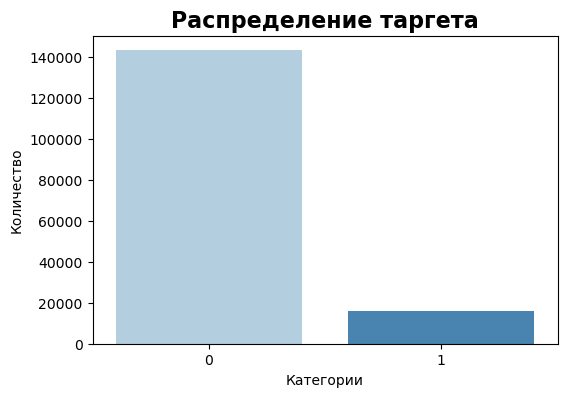

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='toxic', palette='Blues')
plt.title('Распределение таргета', fontsize=16, fontweight='bold')
plt.xlabel('Категории')
plt.ylabel('Количество')

Наблюдаем сильный дисбаланс классов, который следует учитывать.

In [9]:
print(f'Количество выявленных явных дубликатов: {df.duplicated().sum()}')

Количество выявленных явных дубликатов: 0


## Промежуточный вывод

**Цель:** загрузить, предобработать и исследовать данные.
1. Данные загружены в `df` состоят из 3 столбцов и 159292 строк.
2. Пропуски и дубликаты не обнаружены, типы данных коректные.
3. Выявлен дисбаланс классов.
4. Язык комментариев английский.

# Шаг 2. Подготовка признаков и обучение моделей

Токенизацию и лемматизацию проведем с помощью Spacy. 

In [10]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser', 'textcat'])

def clean_and_lemmatize_pipe(texts):
    texts = [re.sub(r'[^a-z\s]', ' ', str(t).lower()) for t in texts]
    docs = nlp.pipe(texts, batch_size=500)
    
    tokenized_docs = []   # списки токенов
    joined_docs = []      # строки для моделей
    
    for doc in docs:
        toks = []
        for token in doc:
            if token.pos_ == 'PRON':
                toks.append(token.text)
            else:
                toks.append(token.lemma_)
        tokenized_docs.append(toks)
        joined_docs.append(' '.join(toks))
    
    return tokenized_docs, joined_docs

In [11]:
%%time
data_model = df.copy()
token_lists, text_strings = clean_and_lemmatize_pipe(df['text'].tolist())

data_model = df.copy()
data_model['text'] = text_strings

train, test = train_test_split(
    data_model, 
    test_size=0.2, 
    random_state=42, 
    stratify=data_model['toxic']
)

CPU times: total: 12min 21s
Wall time: 12min 21s


In [12]:
print(train.shape)
print(test.shape)

(127433, 2)
(31859, 2)


Размеры выборок соответствуют разделению. 

Проведем частотный анализ.

In [13]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

train_fd = train.copy()
train_fd['tokens'] = [token_lists[i] for i in train_fd.index]
train_fd['tokens'] = train_fd['tokens'].apply(lambda toks: [t for t in toks if t not in stop_words and t.strip()])

def get_top_words_simple(df, label, top_n=20):
    tokens = [tok for toks in df[df['toxic'] == label]['tokens'] for tok in toks]
    fdist = FreqDist(tokens)
    top = fdist.most_common(top_n)
    df_top = pd.DataFrame(top, columns=['Слова', 'Количество'])
    df_top['Класс'] = 'toxic' if label == 1 else 'nontoxic'
    return df_top

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


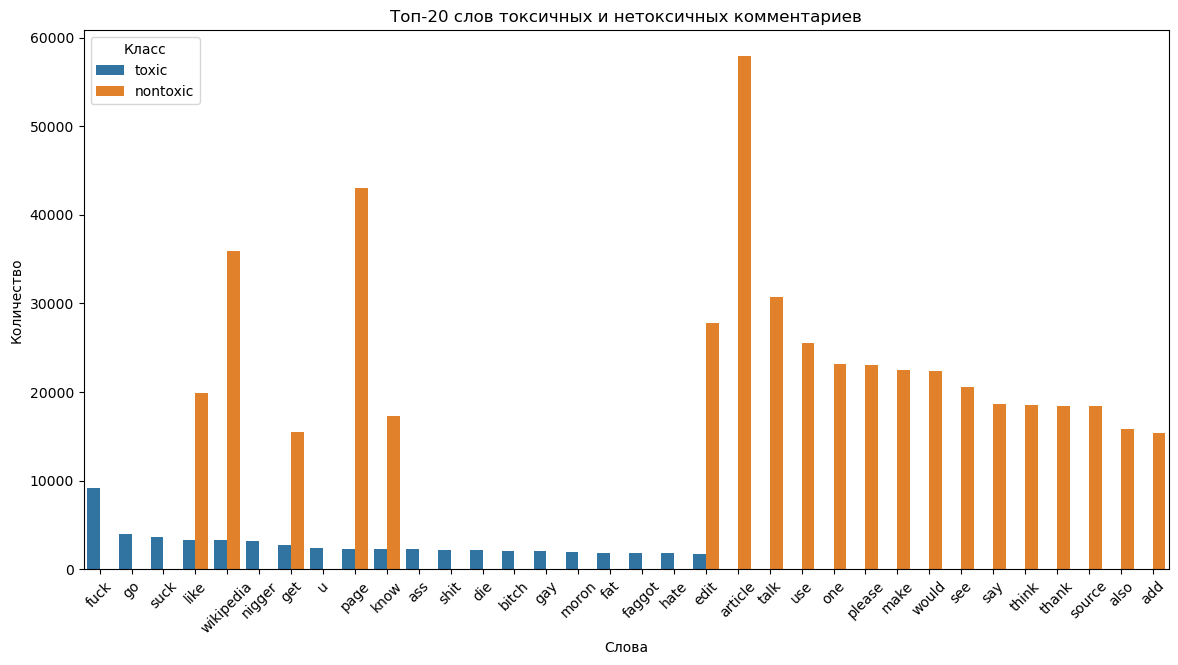

In [14]:
df_freq = pd.concat([get_top_words_simple(train_fd, 1),
                     get_top_words_simple(train_fd, 0)])

plt.figure(figsize=(14,7))
sns.barplot(data=df_freq, x='Слова', y='Количество', hue='Класс')
plt.title('Топ-20 слов токсичных и нетоксичных комментариев')
plt.xticks(rotation=45)
plt.show()

Частота слов нетоксичных комментариев выше, чем токсичных, это обусловлено дисбалансом классов. Но можно отметить самые популярные слова для обоих классов. Некоторые слова являются одинаково индикатороми обоих классов, например такие слова как `like`, `wikipedia`, `get` это объясняется их нейтральной семантикой вне контекста.

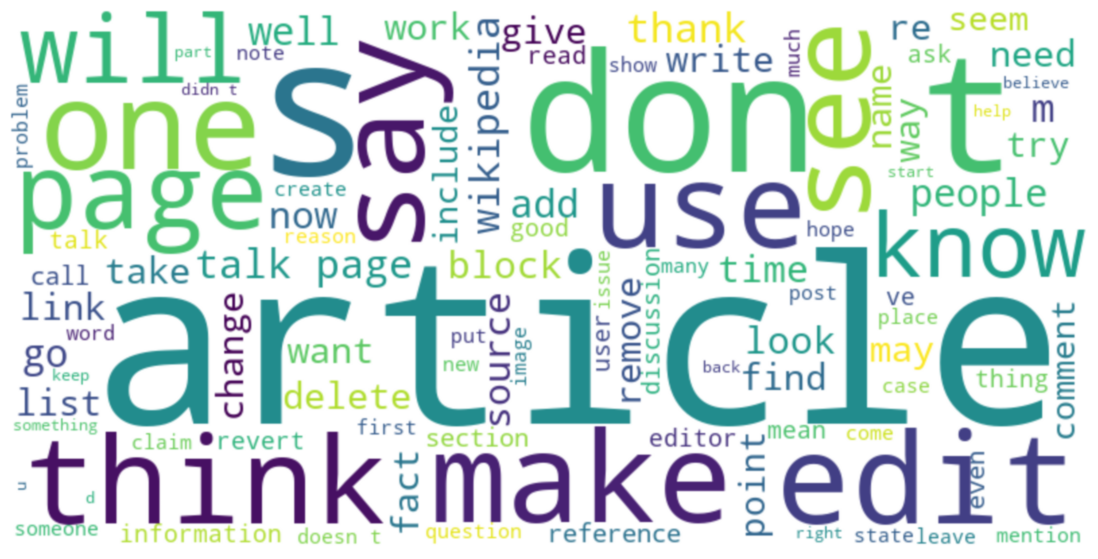

In [15]:
all_tokens = [tok for doc in token_lists for tok in doc]

text_for_wordcloud = ' '.join(all_tokens)

wordcloud = WordCloud(width=800, height=400, max_words=100, colormap='viridis', background_color='white').generate(text_for_wordcloud)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bicubic')
plt.axis("off")
plt.show()

In [16]:
y_train = train['toxic'].values
y_test = test['toxic'].values

Создадим класс для трансформации word2vec. Ограничим длину вектора 300 символами, длину граммы обозначим 5, слова которые использовались менее 2 раз заполняются 0.

In [17]:
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=200, window=5, min_count=2, workers=4, sg=0):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.sg = sg
        self.model = None

    def fit(self, X, y=None):
        sentences = [str(t).split() for t in X]
        self.model = Word2Vec(
            sentences=sentences,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            workers=self.workers,
            sg=self.sg,
            seed=RANDOM_STATE
        )
        return self

    def transform(self, X):
        kv = self.model.wv
        out = np.zeros((len(X), self.vector_size), dtype=np.float32)
        for i, text in enumerate(X):
            words = [w for w in str(text).split() if w in kv.key_to_index]
            if words:
                out[i] = np.mean([kv[w] for w in words], axis=0)
        return out

### Обучение моделей

In [18]:
models = {
    "TF-IDF": [
        {'name': 'LogisticRegression',
         'estimator': LogisticRegression(max_iter=5000, class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
         'params': {'C': [0.1, 1, 10]}
        },
        {'name': 'PassiveAggressiveClassifier',
         'estimator': PassiveAggressiveClassifier(max_iter=5000, random_state=42, class_weight='balanced',n_jobs=-1),
         'params': {'C': [0.1, 1, 10], 'loss':['hinge','squared_hinge']}
        }
    ],
    "Word2Vec": [
        {'name': 'LogisticRegression',
         'estimator': LogisticRegression(max_iter=5000, class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
         'params': {'C': [0.1, 1, 10]}
        },
        {'name': 'PassiveAggressiveClassifier',
         'estimator': PassiveAggressiveClassifier(max_iter=5000, random_state=42, class_weight='balanced',n_jobs=-1),
         'params': {'C': [0.1, 1, 10], 'loss':['hinge','squared_hinge']}
        }
    ]
}

In [19]:
%%time
tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=50000)),
    ('model', LogisticRegression(max_iter=5000, class_weight='balanced', random_state=RANDOM_STATE))
])

tfidf_params = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_features': [10000, 50000, None]
}


grid_tfidf = GridSearchCV(
    tfidf_pipeline,
    param_grid=tfidf_params,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_tfidf.fit(train['text'], train['toxic'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits
CPU times: total: 1min 22s
Wall time: 1min 39s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=50000,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=5000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'tfidf__max_features': [10000, 50000, None],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1', verbose=1)

In [20]:
%%time
w2v_pipeline = Pipeline([
    ('w2v', Word2VecVectorizer(vector_size=200, window=5, min_count=2, sg=0)),
    ('model', LogisticRegression(max_iter=5000, class_weight='balanced', random_state=RANDOM_STATE))
])

w2v_params = {
    'w2v__window': [3,5]
} 

grid_w2v = GridSearchCV(
    w2v_pipeline,
    param_grid=w2v_params,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_w2v.fit(train['text'], train['toxic'])

Fitting 3 folds for each of 2 candidates, totalling 6 fits
CPU times: total: 3min 31s
Wall time: 2min 49s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('w2v', Word2VecVectorizer()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=5000,
                                                           random_state=42))]),
             n_jobs=-1, param_grid={'w2v__window': [3, 5]}, scoring='f1',
             verbose=1)

In [21]:
results = [
    {
        'vectorizer': 'TF-IDF',
        'model': 'LogisticRegression',
        'best_f1_train': grid_tfidf.best_score_,
        'best_params': grid_tfidf.best_params_
    },
    {
        'vectorizer': 'Word2Vec',
        'model': 'LogisticRegression',
        'best_f1_train': grid_w2v.best_score_,
        'best_params': grid_w2v.best_params_
    }
]

results_df = pd.DataFrame(results)
results_df

,vectorizer,model,best_f1_train,best_params
0,TF-IDF,LogisticRegression,0.749811,"{'tfidf__max_features': 50000, 'tfidf__ngram_r..."
1,Word2Vec,LogisticRegression,0.621385,{'w2v__window': 3}


In [22]:
vectorizer = grid_tfidf.best_estimator_.named_steps['tfidf']

X_train_tf = vectorizer.transform(train['text'])

feature_names = vectorizer.get_feature_names() 

tfidf_means = np.asarray(X_train_tf.mean(axis=0)).ravel()

tfidf_df = pd.DataFrame({
    'term': feature_names,
    'tfidf': tfidf_means
})

tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=False).head(30)

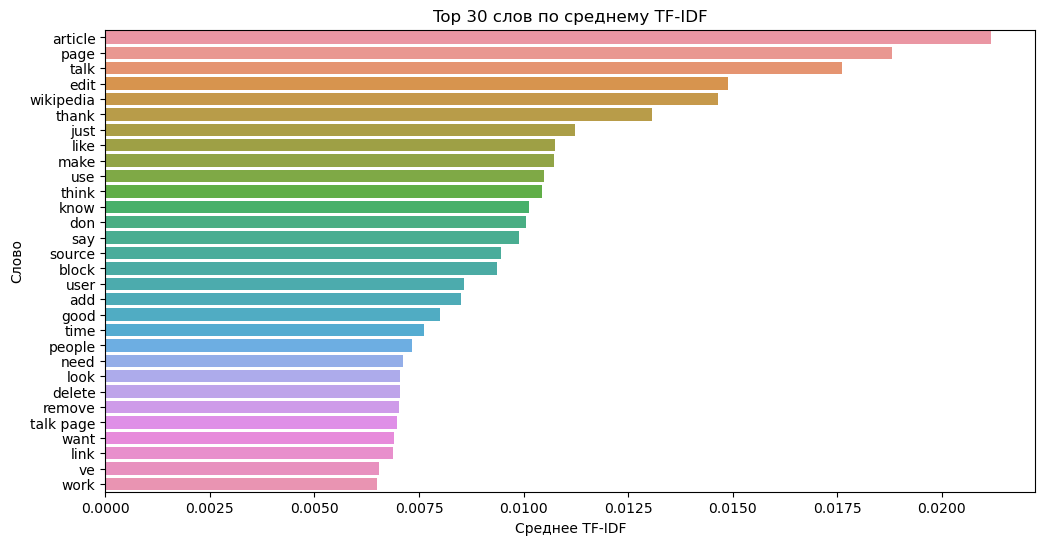

In [23]:
plt.figure(figsize=(12,6))
sns.barplot(x='tfidf', y='term', data=tfidf_df)
plt.title('Top 30 слов по среднему TF-IDF')
plt.xlabel('Среднее TF-IDF')
plt.ylabel('Слово')
plt.show()

TF-IDF недалеко ушло от простой статистики встречаемости слов в тексте. На первом месте так же `article`, `page`. Есть небольшие отличия, но они незначительны.

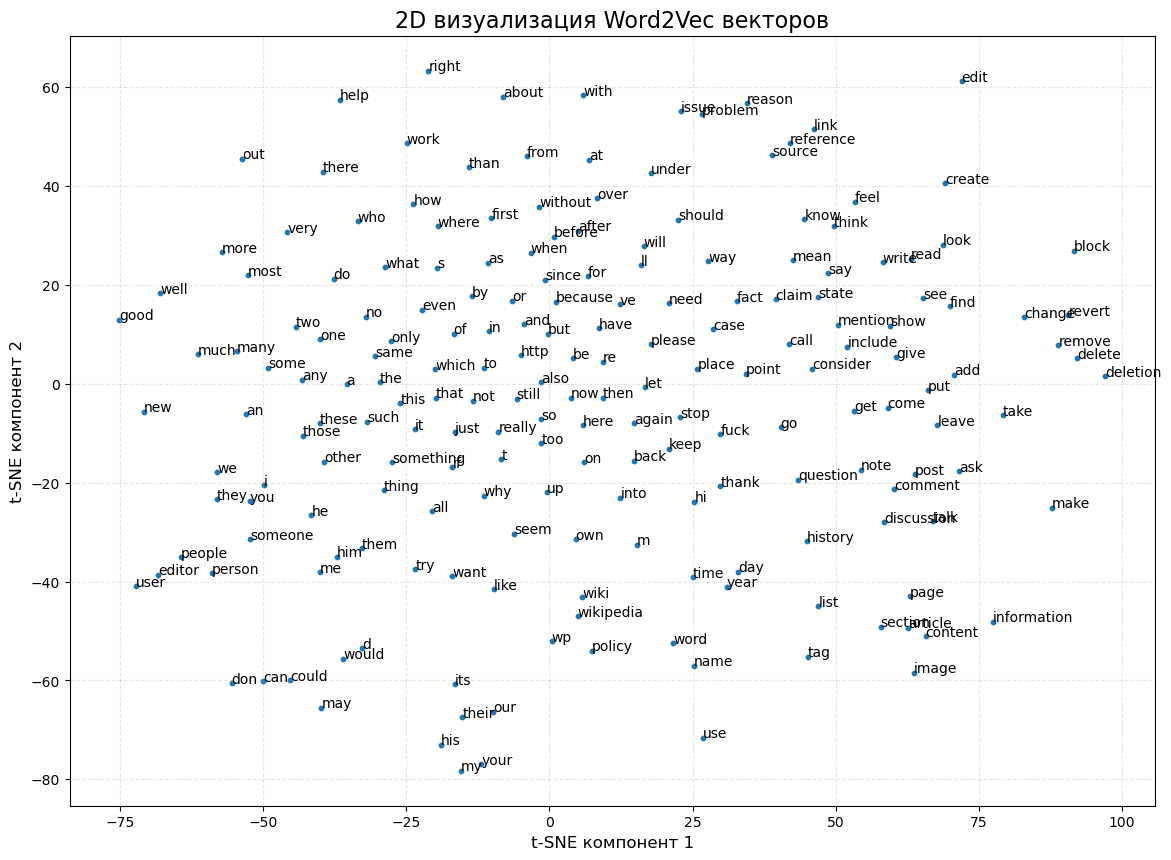

In [24]:
w2v = grid_w2v.best_estimator_.named_steps['w2v']

N = 200
words = list(w2v.model.wv.index_to_key)[:N]
X = w2v.model.wv[words]

tsne = TSNE(n_components=2, random_state=42, perplexity=20)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(14, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=10)

for i, word in enumerate(words):
    plt.annotate(word, (X_tsne[i, 0], X_tsne[i, 1]))
    
plt.title("2D визуализация Word2Vec векторов", fontsize=16)
plt.xlabel("t-SNE компонент 1", fontsize=12)
plt.ylabel("t-SNE компонент 2", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

Word2Vec справилась корректно, слова близкие по семантике располагаются рядом, например "wiki/wikipedia/wp", "remove/delete/deletion".

In [25]:
best_row = results_df.loc[results_df['best_f1_train'].idxmax()]
print(f"Лучшая модель: {best_row['model']}, F1: {best_row['best_f1_train']:.3f}, params: {best_row['best_params']}")

Лучшая модель: LogisticRegression, F1: 0.750, params: {'tfidf__max_features': 50000, 'tfidf__ngram_range': (1, 2)}


Лучше всех справилась стандартная **Logistic Regression обученная на TF-IDF** с метрикой F1 на тренировочной выборке **0.75** с параметром **С=10**.
Скорее всего это связано с тем, что индикатором токсичного комментария являются какие-то определенные слова, а не словосочетания, с негативной окраской, которым Logistic Regression назначает высокие веса и этого хватает для точной классификации.

Узнаем у лучшей модели какие слова получили наибольшие и наименьшие коэффициенты.

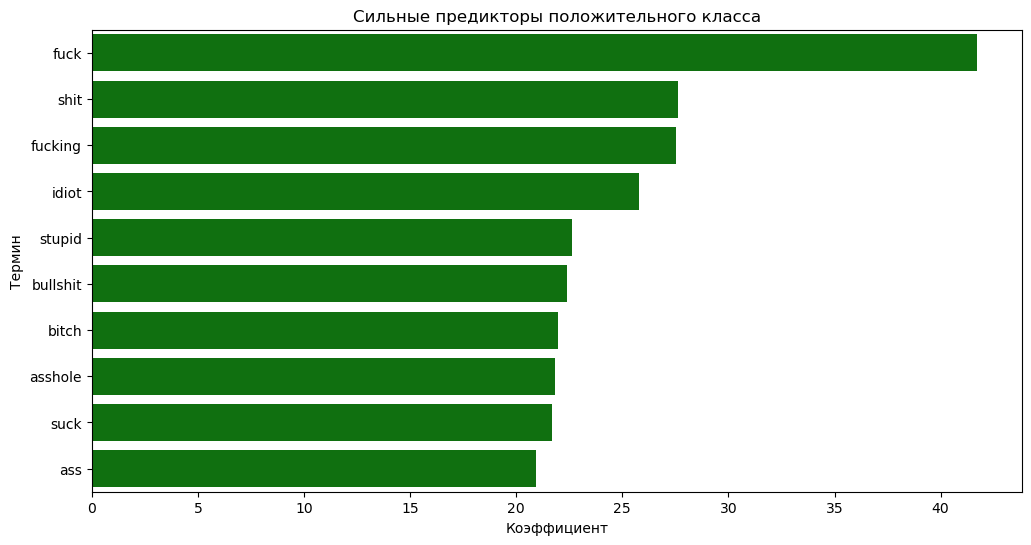

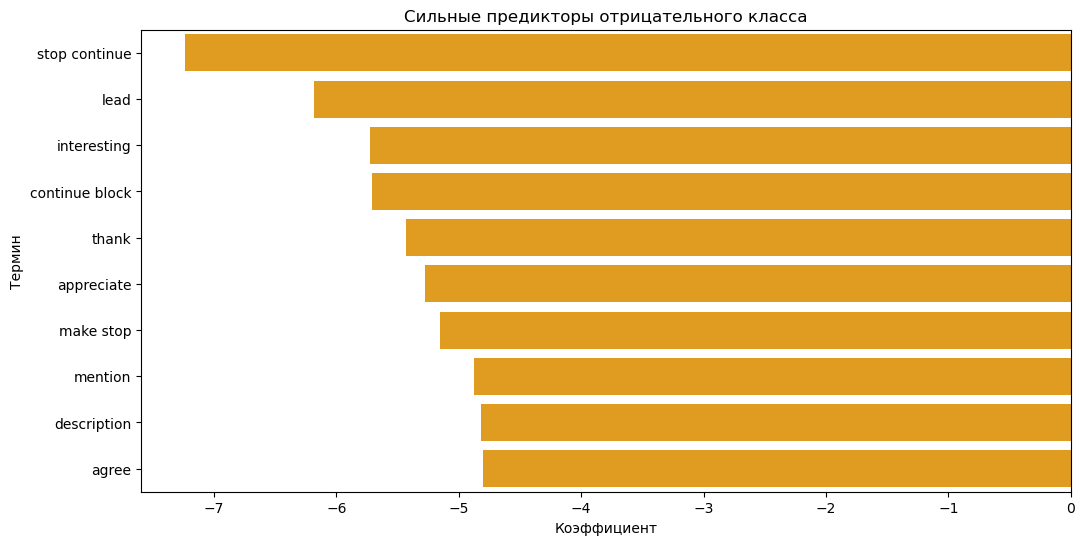

In [26]:
best_model = LogisticRegression(C=10, class_weight='balanced', max_iter=5000,  n_jobs=-1, random_state=RANDOM_STATE)
best_model.fit(X_train_tf, y_train)

coefs = best_model.coef_[0]

df_coef = pd.DataFrame({
    "Термин": feature_names,
    "Коэффициент": coefs
})

top_pos = df_coef.sort_values("Коэффициент", ascending=False).head(10)
top_neg = df_coef.sort_values("Коэффициент", ascending=True).head(10)

plt.figure(figsize=(12,6))

sns.barplot(x="Коэффициент", y="Термин", data=top_pos, color="green")
plt.title("Сильные предикторы положительного класса")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x="Коэффициент", y="Термин", data=top_neg, color="orange")
plt.title("Сильные предикторы отрицательного класса")
plt.show()

Действительно, слова с яркой негативной характеристикой получают наибольший положительный вес. Нейтральные слова и биграммы, например такие как "interesting", "thank" получают неибольшие (но на самом деле небольшие) отрицательные веса.

## Промежуточный вывод

**Цель:** подготовить признаки и обучить модели.   
1. Текст токенизирован и лемматизирован при помощи spaCy.
2. Выборки векторизованы с использованием TF-IDF и Word2Vec.
3. Для кажого типа выборок обучены модели: Logistic Regression, Random Forest, SGDClassifier.
4. Лучшая метрика CV F1 у Logistic Regression обученной на выборке обработанной TF-IDF ngram(1,2)- 0.75.
6. Слова имеюшие наибольший положительный коэффициент (более 20) имеют негативные характеристики.

# Шаг 3. BERT, выбор лучшей модели

Будем использовать модель Toxic Comment Classification.

In [27]:
model_name = "JungleLee/bert-toxic-comment-classification"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print("Используемое устройство:", device)

Используемое устройство: cuda


Обозначим класс, который переведет текст в датасет для удобного использования батчей.  
Создадим функцию, вместо паплайна, чтобы более гибко получить предсказание, потому что у меня падает ядро. В функции мы вручную токенизируем, прогоняем через модель батчи(размером 8),  и собираем предсказание в массив и получаем эмбеддинги.

In [28]:
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        return self.texts[idx]

def get_embeddings(texts, batch_size=8):
    dataset = TextDataset(texts)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_embeddings = []

    with torch.no_grad():
        for batch in loader:
            enc = tokenizer(batch, truncation=True, padding=True, max_length=64, return_tensors="pt")
            input_ids = enc["input_ids"].to(device)
            attention_mask = enc["attention_mask"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_emb = outputs.last_hidden_state[:, 0, :].cpu().numpy() 
            all_embeddings.append(cls_emb)

    return np.vstack(all_embeddings)

Создадим новые выборки с эмбеддингами из исходного датафрейма, без дополнительной предобработки текста, кроме обязательной токенизации для BERT.

In [29]:
data_bert = df.copy() 
train_bert, test_bert = train_test_split( data_bert, test_size=0.2, random_state=RANDOM_STATE, stratify=data_bert['toxic'] ) 

X_train_b = get_embeddings(train_bert['text'].tolist()) 
X_test_b = get_embeddings(test_bert['text'].tolist()) 
y_train_b = train_bert['toxic'].values 
y_test_b = test_bert['toxic'].values 
print("Train:", train_bert.shape) 
print("Test:", test_bert.shape)

Train: (127433, 2)
Test: (31859, 2)


Обучим маленькую нейросеть из двух линейных слоев (один скрытый слой). Функция потерь — стандартная кросс-энтропия. Оптимизатор — Adam с learning rate 0.001.

In [31]:
class EmbeddingClassifier(pl.LightningModule):
    def __init__(self, input_dim=768, hidden_dim=128, output_dim=2, lr=1e-3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.lr = lr
        self.loss_fn = nn.CrossEntropyLoss()

        self.train_f1 = torchmetrics.F1Score(task="binary")
        self.test_f1  = torchmetrics.F1Score(task="binary")

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_f1.update(preds, y)
        self.log("train_loss", loss)
        self.log("train_f1", self.train_f1, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        self.test_f1.update(preds, y)
        self.log("test_f1", self.test_f1, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [32]:
train_dataset = TensorDataset(torch.tensor(X_train_b, dtype=torch.float32),
                              torch.tensor(y_train_b, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(torch.tensor(X_test_b, dtype=torch.float32),
                             torch.tensor(y_test_b, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=32)

In [33]:
trainer = pl.Trainer(max_epochs=10, accelerator='gpu')
model_clf = EmbeddingClassifier()
trainer.fit(model_clf, train_loader)

trainer.test(model_clf, dataloaders=test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
E:\Anaconda2\envs\practicum\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
E:\Anaconda2\envs\practicum\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.8553157448768616     │
└───────────────────────────┴───────────────────────────┘

[{'test_f1': 0.8553157448768616}]

In [37]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(train['text'])
X_test_tfidf  = vectorizer.transform(test['text'])

best_model.fit(X_train_tfidf, train['toxic'])
y_pred_test = best_model.predict(X_test_tfidf)
f1_test = f1_score(test['toxic'], y_pred_test)
print(f"F1 на тесте: {f1_test:.3f}")

F1 на тесте: 0.761


Модель **BERT Toxic Comment Classification** показала более высокое качество по метрике F1 как на тестовой ( 0.855) выборкке, по сравнению с **Logistic Regression на TF-IDF** (0.761). Таким образом, использование предобученного трансформера даёт выигрыш по качеству на данной задаче. Так же линейной модели помогла нейросеть с одним скрытым слоем, которая помогла уловаить нелинейные связи.

## Промежуточный вывод

**Цель:** загрузить модель BERT, выбрать лучшую модель.   
1. C HuggingFace загружена модель BERT  Toxic Comment Classification.
2. Получены эмбеддинги и маленькая нейронная сеть с одним скрытым слоем, функция потерь - кросс энтропия.
3. BERT помог добиться на нейронной сети F1 = 855.
4. Лучшая модель — небольшая нейронная сеть с одним скрытым слоем, функцией потерь кросс-энтропией и скоростью обучения 0.001, обученная на признаках, полученных с помощью предобученного трансформера BERT Toxic Comment Classification.

# Общий вывод

Целью проекта было обучение модели для автоматического выявления токсичных комментариев в сервисе интернет-магазина «Викишоп», чтобы направлять их на модерацию.

**Были выполнены задачи:**
1) Загрузка, предобработка и исследование данных.
   Данные содержали 159 292 комментария на английском языке. Пропусков и дубликатов не выявлено, типы данных корректные. Обнаружен дисбаланс классов.

2) Подготовка признаков и моделей.
Тексты были токенизированы и лемматизированы с помощью spaCy. Построены векторные представления через TF-IDF и Word2Vec. Для этих признаков обучены модели Logistic Regression, Random Forest и SGDClassifier. Лучший результат показала Logistic Regression на TF-IDF с метрикой **F1 = 0.750** на кросс валидации.

3) Использование BERT и выбор лучшей модели.
С помощью библиотеки HuggingFace Transformers была загружена предобученная модель **BERT Toxic Comment Classification**. С помощью нее получены эмбеддинги, которые загрузили в нейронную сеть с одним скрытым слоем, функция потерь - кросс энтропия. На тестовой выборках модель показала стабильное качество **F1 = 0.885**, превысив результаты классических моделей.

**Общий вывод.**
Лучшая модель — небольшая нейронная сеть с одним скрытым слоем, функцией потерь кросс-энтропией и скоростью обучения 0.001, обученная на признаках, полученных с помощью предобученного трансформера BERT Toxic Comment Classification. Она обеспечивает более высокую метрику F1 по сравнению с классическими моделями на TF-IDF и Word2Vec.